# LetsGrowMore (LGMVIP) - "DATA SCIENCE INTERNSHIP"
## LGMVIP Aug-22
## Ayush Dilip Padvekar
## Task - 8 Next Word Prediction
In this project we will be using Tensorflow and Keras library to train a RNN model and using that model we will predict the next word in the text from the dataset.

Dataset Link: https://drive.google.com/file/d/1GeUzNVqiixXHnTl8oNiQ2W3CynX_lsu2/view

### Importing Libraries

In [1]:
import numpy as np
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import LSTM
from keras.layers.core import Dense, Activation
from tensorflow.keras.optimizers import RMSprop
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import pickle
import heapq

np.random.seed(42)

import warnings
warnings.filterwarnings("ignore")

### Loading the Dataset

In [2]:
path = '1661-0.txt'
txt = open(path, encoding='utf-8').read().lower()
print('corpus length', len(txt))

corpus length 581888


In [3]:
chars = sorted(list(set(txt)))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))
print ("unique chars: ",len(chars))

unique chars:  73


### Feature Engineering

In [4]:
SEQUENCE_LENGTH = 39
step = 3
sentences = []
next_chars = []
for i in range(0, len(txt) - SEQUENCE_LENGTH, step):
    sentences.append(txt[i:i+SEQUENCE_LENGTH])
    next_chars.append(txt[i+SEQUENCE_LENGTH])
print ('num training examples: ',len(sentences))


num training examples:  193950


In [5]:
X = np.zeros((len(sentences), SEQUENCE_LENGTH, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

In [6]:
print(X[0][0])

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
  True]


### Model Building

In [7]:
model = Sequential();
model.add(LSTM(128, input_shape=(SEQUENCE_LENGTH, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               103424    
                                                                 
 dense (Dense)               (None, 73)                9417      
                                                                 
 activation (Activation)     (None, 73)                0         
                                                                 
Total params: 112,841
Trainable params: 112,841
Non-trainable params: 0
_________________________________________________________________


### Model Training

In [8]:
optimizer = RMSprop(lr= 0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X, y, validation_split=0.05, batch_size=128, epochs=20, shuffle=True).history

Epoch 1/20
1440/1440 [==============================] - 149s 100ms/step - loss: 1.9682 - accuracy: 0.4230 - val_loss: 2.1121 - val_accuracy: 0.4140
Epoch 2/20
1440/1440 [==============================] - 149s 104ms/step - loss: 1.6159 - accuracy: 0.5159 - val_loss: 2.0442 - val_accuracy: 0.4359
Epoch 3/20
1440/1440 [==============================] - 156s 108ms/step - loss: 1.5148 - accuracy: 0.5437 - val_loss: 2.0398 - val_accuracy: 0.4536
Epoch 4/20
1440/1440 [==============================] - 186s 129ms/step - loss: 1.4640 - accuracy: 0.5571 - val_loss: 2.0315 - val_accuracy: 0.4567
Epoch 5/20
1440/1440 [==============================] - 186s 129ms/step - loss: 1.4290 - accuracy: 0.5664 - val_loss: 2.0232 - val_accuracy: 0.4570
Epoch 6/20
1440/1440 [==============================] - 153s 106ms/step - loss: 1.4058 - accuracy: 0.5727 - val_loss: 2.0182 - val_accuracy: 0.4688
Epoch 7/20
1440/1440 [==============================] - 152s 106ms/step - loss: 1.3853 - accuracy: 0.5776 - val_

### Saving the Trained Model

In [9]:
model.save('LGMVIP_Task8_model.h5')
pickle.dump(history, open("history.p", "wb"))
model = load_model('LGMVIP_Task8_model.h5')
history = pickle.load(open("history.p", "rb"))

### Evaluating the Next Word Prediction Model

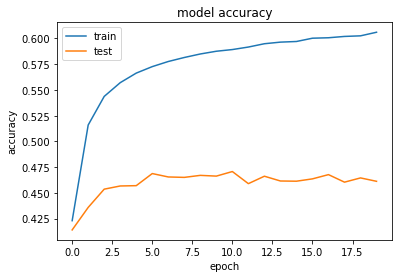

In [10]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.savefig("Task8_Accuracy.png")

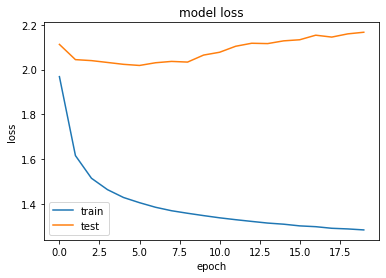

In [11]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc= 'best')
plt.savefig("Task8_Loss.png")

### Testing Next Word Prediction Model

In [12]:
def prepare_input(text):
    x = np.zeros((1, SEQUENCE_LENGTH, len(chars)))
    for t, char in enumerate(text):
        x[0, t, char_indices[char]] = 1
    return x

### The Sample function

In [13]:
def sample(preds, top_n = 3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    return heapq.nlargest(top_n, range(len(preds)), preds.take)

### Prediction function

In [14]:
def predict_completion(text):
    original_text = text
    generalised = text
    completion = ''
    while True:
        x = prepare_input(text)
        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, top_n=1)[0]
        next_char = indices_char[next_index]
    text = txt[1:] + next_char
    completion += next_char
    if len(original_text + completion) + 2 > len(original_text) and next_char == ' ':
                return completion

### Prediction of multiple completions

In [15]:
def predict_completions(text, n = 3):
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [indices_char[idx] + predict_completion(text[1:] + indices_char[idx]) for idx in next_indices]

In [16]:
# Sample Test case
quotes = [
    "It is not a lack of love, but a lack of friendship that makes unhappy marriages.",
    "That which does not kill us makes us stronger.",
    "I'm not upset that you lied to me, I'm upset that from now on I can't believe you.",
    "And those who were seen dancing were thought to be insane by those who could not hear the music.",
    "It is hard enough to remember my opinions, without also remembering my reasons for them!"
]

In [ ]:
for q in quotes:
    seq = q[:SEQUENCE_LENGTH].lower()
    print (seq)
    print (predict_completions(seq, 5))
    print ()

it is not a lack of love, but a lack of
